In [1]:
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from torch.optim import AdamW
from scipy.optimize import minimize, fsolve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import os
import gc
from tqdm import tqdm
import sys
sys.path.append("../src")
from config import read_config, update_config
from metric import cal_mae_metric
from util import smart_avg,reduce_mem_usage
from FE import add_features_choice
from dataset import read_data, prepare_train_valid, VPP, cls_2_num_func
from models import get_model
from util import *

In [2]:
config = read_config("Base")
config.gpu = [0]
config = update_config(config)

Using device: cuda
Number of device: 1
Model Output Folder: /home/vincent/Kaggle/GBVPP/output/Base/


In [3]:
subs = {
    "Public_PulpFriction_New_Physics": "../output/Public_PulpFriction_New_Physics/test_pred_all_16515.csv",
    
    "LSTM5_CLS_FIXED_NoErr1_noCS_PL": "../output/LSTM5_CLS_FIXED_NoErr1_noCS_PL/test_pred_all_14748.csv",
    "LSTM5_REG_LARGER_physics_noCS_noErr1_PL": "../output/LSTM5_REG_LARGER_physics_noCS_noErr1_PL/test_pred_all_15036.csv",
    "LSTM5_CLS_LARGER512x3842x2562_NoErr1_noCS_PL": "../output/LSTM5_CLS_LARGER512x3842x2562_NoErr1_noCS_PL/test_pred_all_14237.csv",
    
    "LSTM5_REG_physics_noCS_PL" : "../output/LSTM5_REG_physics_noCS_PL/test_pred_all_16991.csv",
    "LSTM5_REG_LARGER_physics_noCS_PL":"../output/LSTM5_REG_LARGER_physics_noCS_PL/test_pred_all_16841.csv",
    
    "LSTM5_CLS_FIXED_noCS_PL": "../output/LSTM5_CLS_FIXED_noCS_PL/test_pred_all_16417.csv",
    "LSTM5_CLS_LARGER512x3842x2562_noCS_PL": "../output/LSTM5_CLS_LARGER512x3842x2562_noCS_PL/test_pred_all_15908.csv"
}
ensemble_folder = config.output_folder + "/" + "ensemble_1103"
if not os.path.exists(ensemble_folder):
    os.makedirs(ensemble_folder)

In [4]:
train, test = read_data(config)

In [5]:
pressure_unique = np.load("/home/vincent/Kaggle/GBVPP/input/pressure_unique.npy")

In [6]:
P_MIN = np.min(pressure_unique)
P_MAX = np.max(pressure_unique)
P_STEP = pressure_unique[1] - pressure_unique[0]
def transform_pv(s):
    t = (np.round((s - P_MIN) / P_STEP) * P_STEP + P_MIN)
    return np.clip(t, P_MIN, P_MAX)

# Regenerate Valid Prediction If necessary

In [7]:
def get_valid_pred(valid_loader, model, device):
    model.eval()
    preds = []
    for step, batch in enumerate(valid_loader, 1):
        with torch.no_grad():
            X = batch[0].to(device)
            outputs = model(X).squeeze()
            preds.append(outputs.to('cpu').detach().numpy())
    predictions = np.concatenate(preds, axis=0)
    return predictions

In [8]:
key = None
key_cvs = []
if key is not None:
    print(f"Check Model {key} CV")
    model_config =  read_config(key)
    model_config.gpu = [1]
    model_config = update_config(model_config)
    train = add_features_choice(train.copy(), model_config)
    train, NAlist = reduce_mem_usage(train)
    for fold in range(5):
        X_train, y_train, w_train, X_valid, y_valid, w_valid = prepare_train_valid(train.copy(), model_config, fold)
        valid_dt = VPP(X_valid, y_valid, w_valid, model_config)
        valid_loader = DataLoader(valid_dt,
                                  batch_size=model_config.batch_size,
                                  shuffle=False,
                                  num_workers=model_config.num_workers, pin_memory=True, drop_last=False)       
        model = get_model(X_valid.shape[-1], model_config)
        checkpoint = torch.load(f'{model_config.model_output_folder}/Fold_{fold}_best_model.pth')
        model.load_state_dict((checkpoint['model_state_dict']))
        print("Model Size: {}".format(get_n_params(model)))
        model.to(model_config.device)
        oof_preds = get_valid_pred(valid_loader, model, model_config.device)
        if not model_config.do_reg:
            oof_preds = cls_2_num_func(oof_preds.argmax(axis=-1), model_config.pressure_unique_path)
        cv = (np.abs( oof_preds-y_valid ) * w_valid).sum()/w_valid.sum()
        key_cvs.append(cv)
        print(f"Fold {fold}, CV: {cv:.5f}")
        np.save(model_config.model_output_folder + f"/oof{fold}", oof_preds)

# Read Data

In [9]:
sub_all = None
for key, sub_file in tqdm(subs.items()):
    train[key] = 0
    tmp = pd.read_csv(sub_file)
    if sub_all is None:
        sub_all = tmp[["id","pressure"]].copy()
        sub_all["pressure"] = 0
        
    for fold in range(5):
        if "Public_PulpFriction" in key or "noerr1" in key.lower():
            train.loc[train.query(f"fold=={fold}").index, key] = np.load(f'../output/{key}/oof{fold}.npy').flatten()
        else:
            train.loc[train.query(f"fold=={fold}").index, key] = torch.load(f'../output/{key}/Fold_{fold}_best_model.pth')['valid_preds'].flatten()
        sub_all[key+f"_{fold}"] = tmp[f"preds_fold{fold}"]
    train[key] = transform_pv(train[key])
    sub_all[key] = smart_avg(sub_all[[key+f"_{f}" for f in range(5)]],axis=1)
    sub_all[key] = transform_pv(sub_all[key])

100%|█████████████████████████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.38s/it]


In [10]:
for key, sub_file in subs.items():
    CV = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df[key],1-df["u_out"])).mean()
    print(f"Model {key} CV {CV:.5f}")

Model Public_PulpFriction_New_Physics CV 0.16515
Model LSTM5_CLS_FIXED_NoErr1_noCS_PL CV 0.16463
Model LSTM5_REG_LARGER_physics_noCS_noErr1_PL CV 0.16767
Model LSTM5_CLS_LARGER512x3842x2562_NoErr1_noCS_PL CV 0.15914
Model LSTM5_REG_physics_noCS_PL CV 0.16991
Model LSTM5_REG_LARGER_physics_noCS_PL CV 0.16841
Model LSTM5_CLS_FIXED_noCS_PL CV 0.16417
Model LSTM5_CLS_LARGER512x3842x2562_noCS_PL CV 0.15908


In [11]:
model_cols = list(subs.keys())
train["oof_avg"] =  transform_pv(train[model_cols].mean(axis=1))
train["oof_median"] =  transform_pv(train[model_cols].median(axis=1))
train["oof_smart"] =  transform_pv(smart_avg(train[model_cols], axis=1))
for key in ['oof_avg', 'oof_median', 'oof_smart']:
    CV = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df[key],1-df["u_out"])).mean()
    print(f"{key} CV {CV:.5f}")

oof_avg CV 0.14885
oof_median CV 0.14786
oof_smart CV 0.14719


In [12]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold,Public_PulpFriction_New,...,LSTM5_REG_physics_PL_better_2,LSTM5_REG_physics_noCS_PL,LSTM5_REG_LARGER_physics_noCS_PL,LSTM5_CLS_FIXED_noCS_PL,LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,oof_avg,oof_median,oof_smart
0,1,1,20,50,0.000000,0.083334,0,5.837492,4,5.837492,...,5.767190,5.978096,5.837492,5.767190,5.837492,5.767190,5.837492,5.837492,5.837492,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794,4,5.978096,...,5.837492,5.907794,5.837492,5.837492,5.907794,5.837492,5.837492,5.837492,5.837492,5.837492
2,3,1,20,50,0.067514,22.509277,0,7.876254,4,8.016858,...,7.946556,7.876254,7.876254,7.805952,7.946556,7.876254,7.876254,7.876254,7.876254,7.876254
3,4,1,20,50,0.101542,22.808823,0,11.742872,4,11.883476,...,11.813174,11.813174,11.953778,11.883476,11.883476,11.883476,11.953778,11.883476,11.883476,11.883476
4,5,1,20,50,0.135756,25.355850,0,12.234987,4,12.375591,...,12.516196,12.516196,12.586498,12.516196,12.516196,12.445893,12.516196,12.445893,12.445893,12.445893


In [13]:
sub_all.head()

,id,pressure,Public_PulpFriction_New_0,Public_PulpFriction_New_1,Public_PulpFriction_New_2,Public_PulpFriction_New_3,Public_PulpFriction_New_4,Public_PulpFriction_New,Public_PulpFriction_New_Physics_0,Public_PulpFriction_New_Physics_1,...,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_2,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_3,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_4,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_0,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_1,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_2,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_4,LSTM5_CLS_LARGER512x3842x2562_noCS_PL
0,1,0,6.329606,6.329606,6.329606,6.259304,6.329606,6.329607,6.329606,6.259304,...,6.259305,6.259305,6.189002,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305
1,2,0,5.978096,5.978096,5.978096,5.907794,5.978096,5.978096,5.978096,5.978096,...,5.907794,5.907794,5.978096,5.907794,5.978096,5.978096,5.907794,5.907794,5.978096,5.978096
2,3,0,7.032628,7.173232,7.102930,7.102930,7.173232,7.102930,6.962326,7.102930,...,7.102930,7.102930,7.102930,7.102930,7.102930,7.173232,7.102930,7.102930,7.102930,7.102930
3,4,0,7.595045,7.735649,7.595045,7.595045,7.665347,7.665347,7.665347,7.665347,...,7.524743,7.665347,7.665347,7.595045,7.595045,7.595045,7.595045,7.595045,7.665347,7.595045
4,5,0,9.141692,9.211994,9.001088,9.141692,9.141692,9.141693,9.141692,9.282296,...,9.001088,9.141693,9.071390,9.071390,9.071390,9.141693,9.071390,9.141693,9.141693,9.141693


# Error Analysis

In [14]:
def plot_error(df, ax, breath_id):
    breath = df.query(f"breath_id == {breath_id}").copy()
    R, C = breath.iloc[0][["R","C"]]
    best_choice = None
    best_score = np.inf
    for col in ["oof_smart", 
                "Public_PulpFriction_New_Physics", 
                "LSTM5_CLS_LARGER512x3842x2562_NoErr1_noCS_PL", 
                "LSTM5_REG_LARGER_physics_noCS_PL", 
                "LSTM5_CLS_LARGER512x3842x2562_noCS_PL"]:
        score = np.mean(np.abs(breath["pressure"] - breath[col]))
        if score < best_score:
            best_score = score
            best_choice = col
    
    ax.plot(breath["time_step"],breath["pressure"],label="y_true")
    ax.plot(breath["time_step"],breath["oof_smart"],label="y_pred")
    #ax.plot(breath["time_step"],breath["u_in"],label="u_in")
    
    ax.plot(breath["time_step"],breath["Public_PulpFriction_New_Physics"],label="p_pulp")
    ax.plot(breath["time_step"],breath["LSTM5_CLS_LARGER512x3842x2562_NoErr1_noCS_PL"],label="p_noErr1")
    ax.plot(breath["time_step"],breath["LSTM5_REG_LARGER_physics_noCS_PL"],label="p_reg")
    ax.plot(breath["time_step"],breath["LSTM5_CLS_LARGER512x3842x2562_noCS_PL"],label="p_cls")    
    
    
#     diff = breath["pressure"] - breath["oof_smart"]
#     ax2 = ax.twinx()
#     ax2.plot(breath["time_step"], diff, label='diff', color="red")
#     ax2.axhline(y=CV, color="red", linestyle="--", alpha=.3)
#     ax2.axhline(y=0, color="red", linestyle="--", alpha=.3)
#     ax2.axhline(y=-CV, color="red", linestyle="--", alpha=.3)
    ax.legend(loc="lower right")
#     ax2.legend(loc="upper right")
    ax.set_title(f"id: {breath_id}, R:{R}, C:{C}. Best Choice: {best_choice}")
    ax.grid(axis='x')

In [15]:
related_train = train.query("u_out == 0").copy()
RC_score = related_train.groupby(["R","C"]).apply(lambda df: np.mean(np.abs(df["pressure"] - df["oof_smart"])))
RC_score

R   C 
5   10    0.137274
    20    0.093271
    50    0.098311
20  10    0.139023
    20    0.139173
    50    0.137595
50  10    0.138132
    20    0.210671
    50    0.225521
dtype: float64

In [16]:
breath_score = related_train.groupby("breath_id").apply(lambda df: np.mean(np.abs(df["pressure"] - df["oof_smart"])))

In [17]:
bad_score = breath_score[breath_score > 1]

In [18]:
len(bad_score)

817

In [19]:
good_score = breath_score[breath_score < .1]

In [20]:
len(good_score)

43508

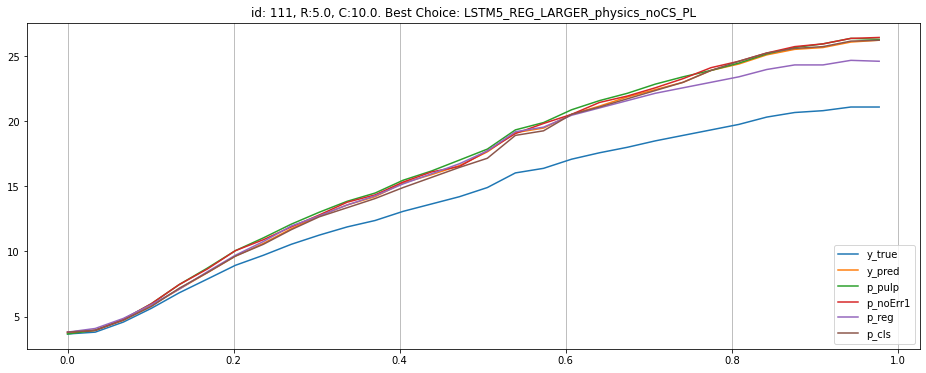

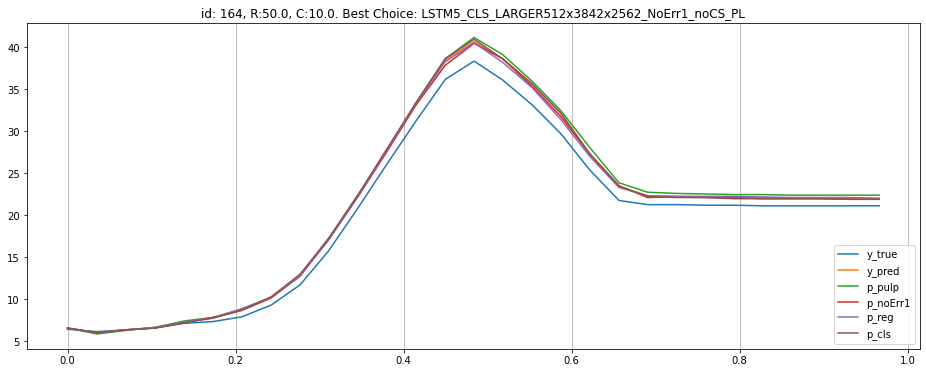

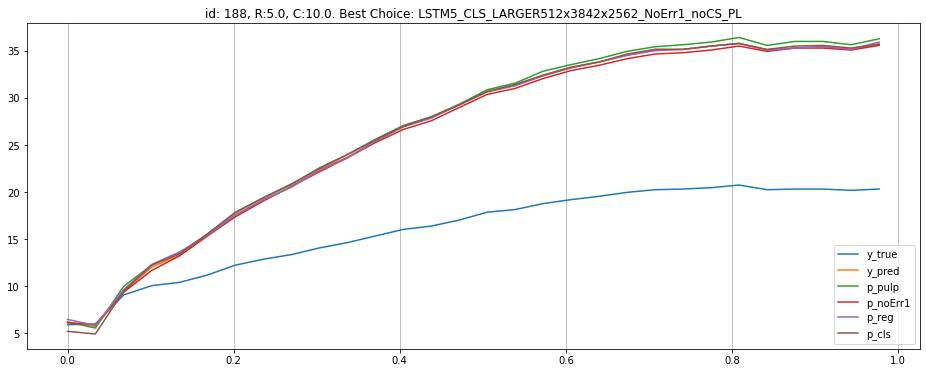

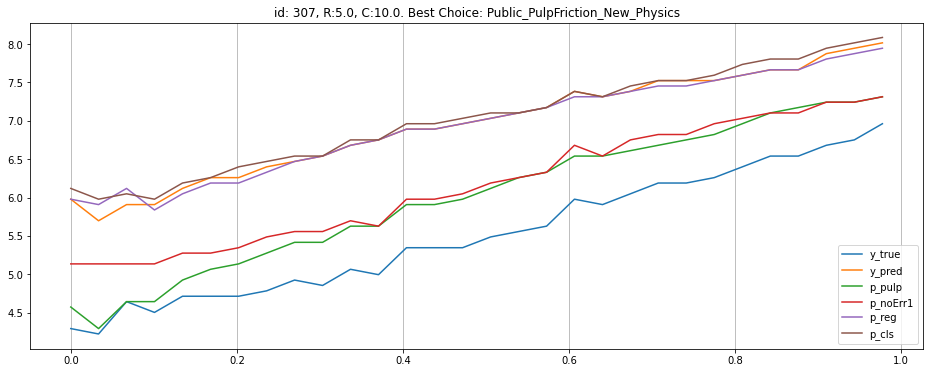

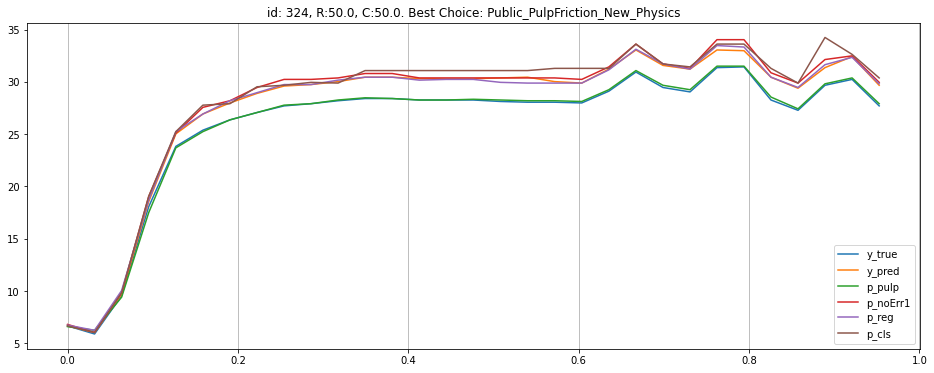

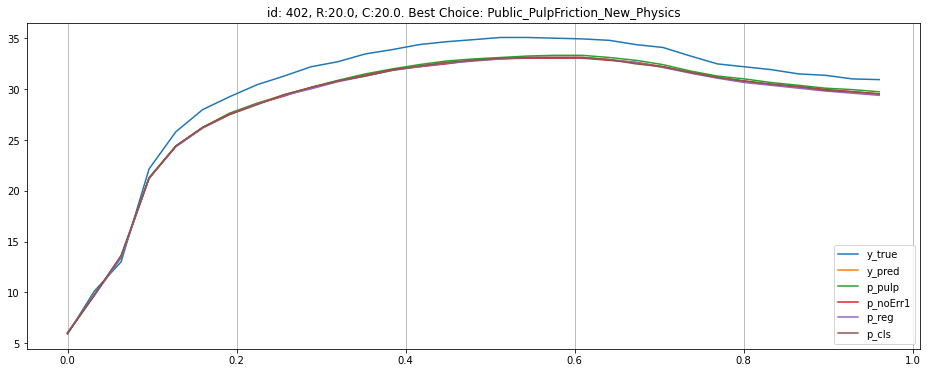

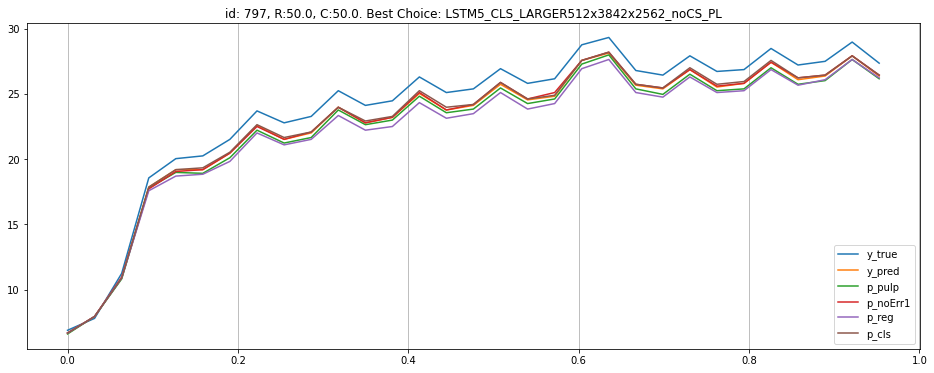

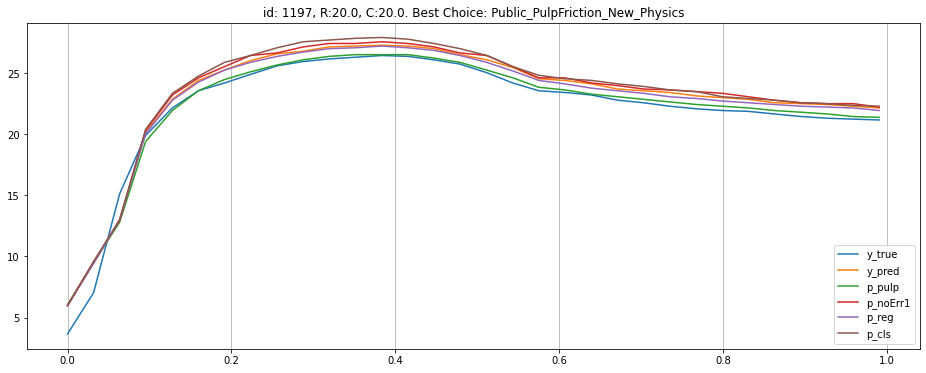

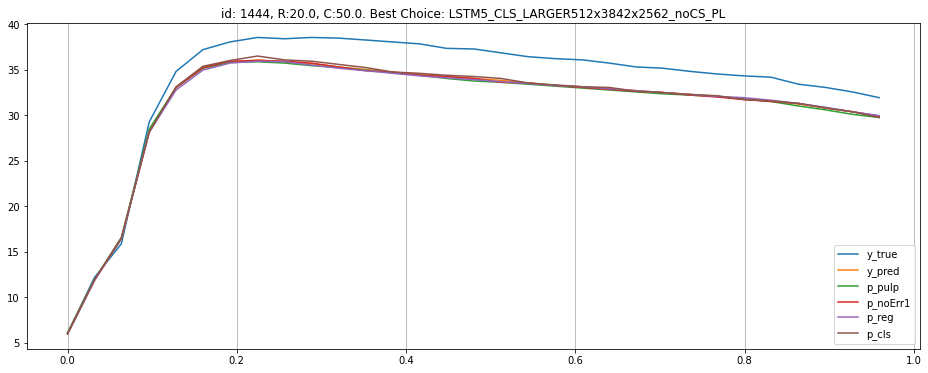

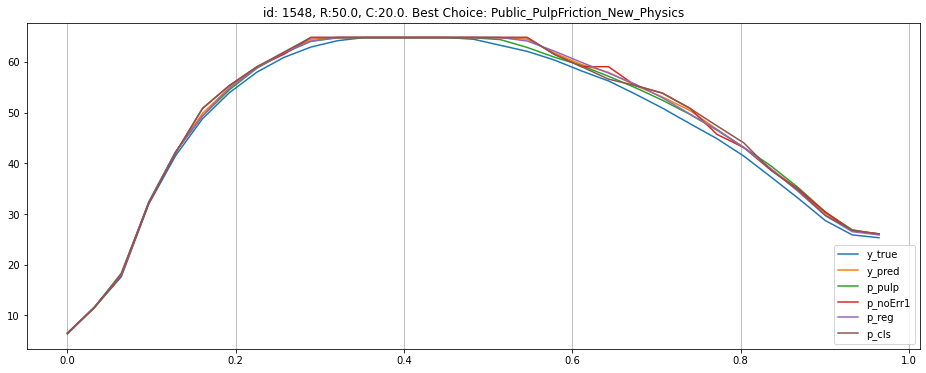

In [21]:
for i in range(10):    
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    plot_error(related_train, ax, bad_score.index[i])

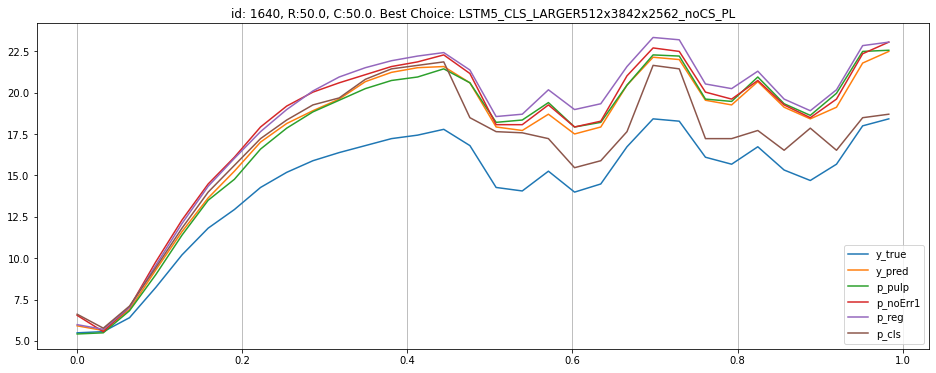

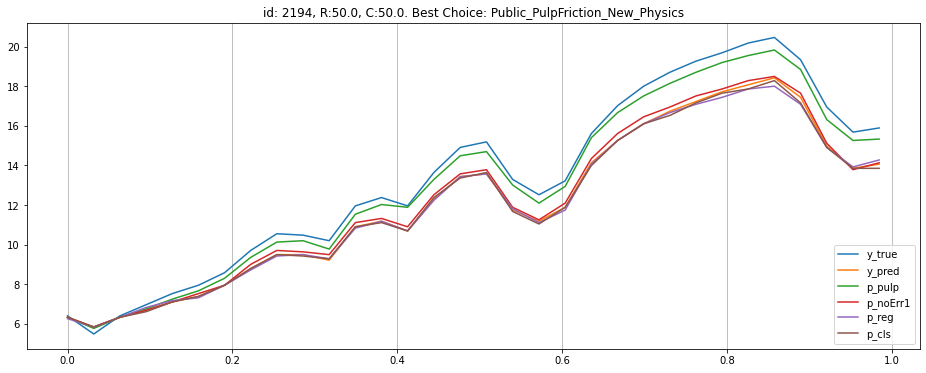

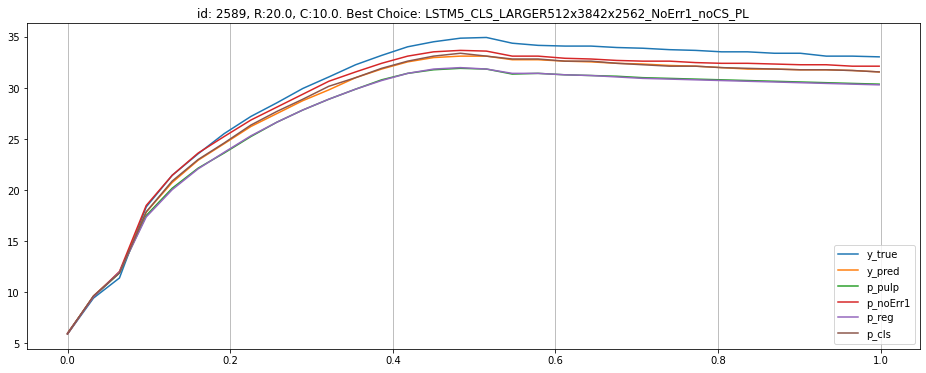

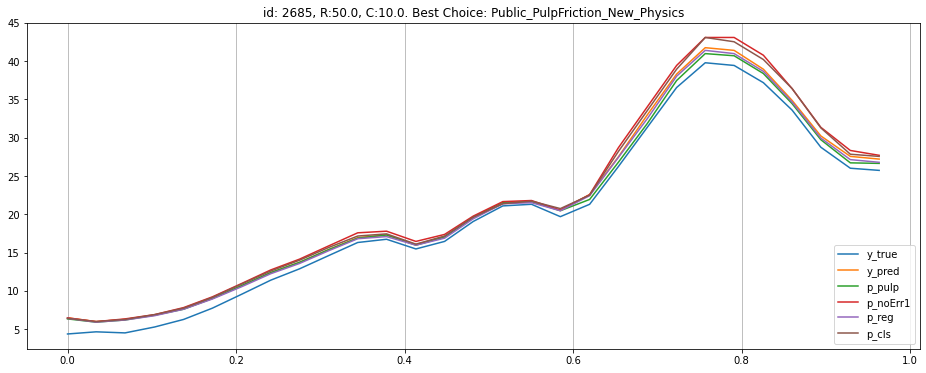

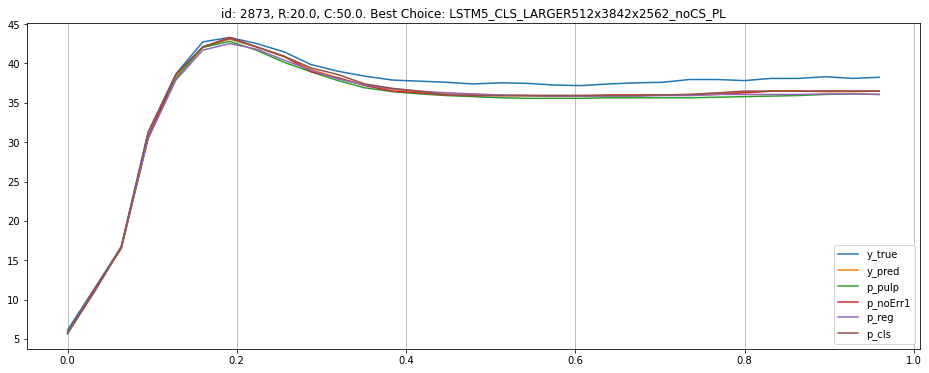

In [22]:
for i in range(10, 15):    
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    plot_error(related_train, ax, bad_score.index[i])

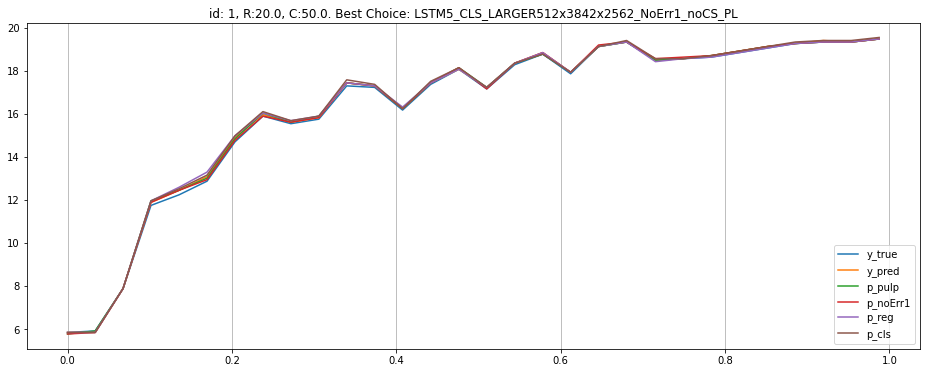

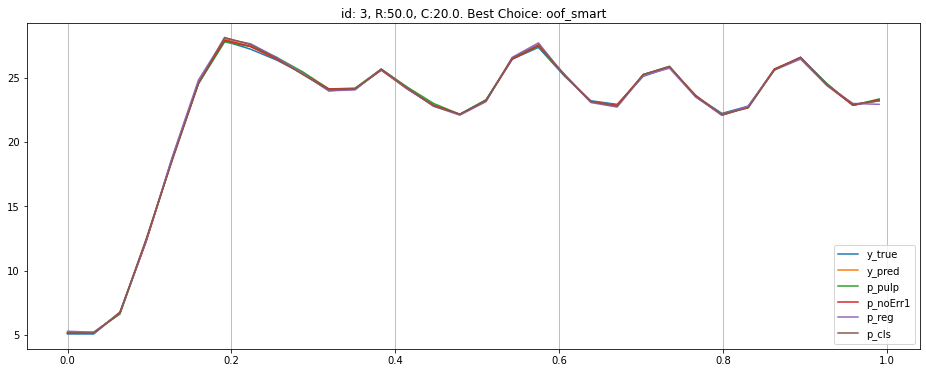

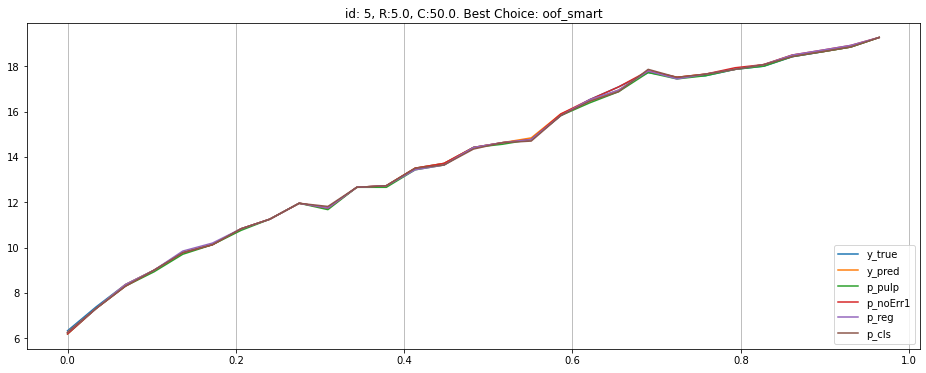

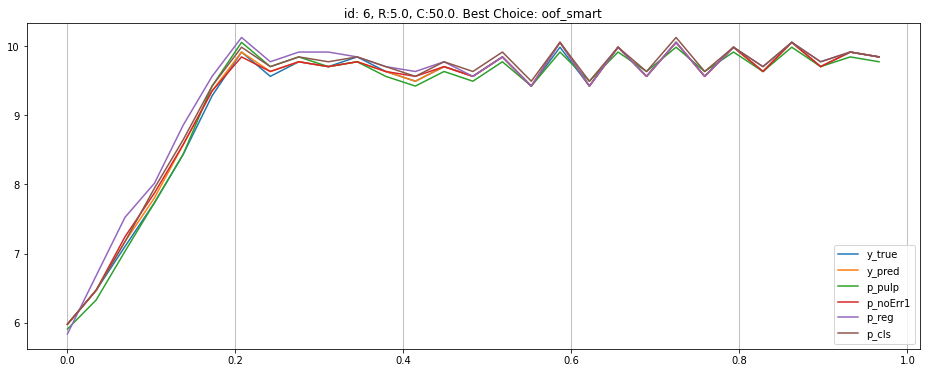

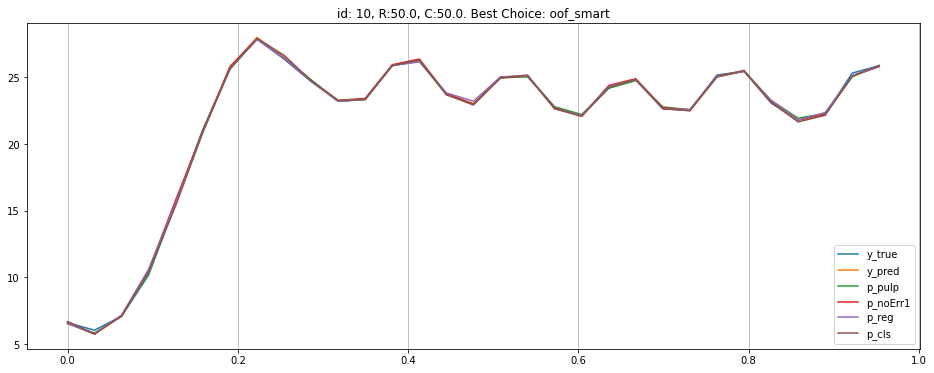

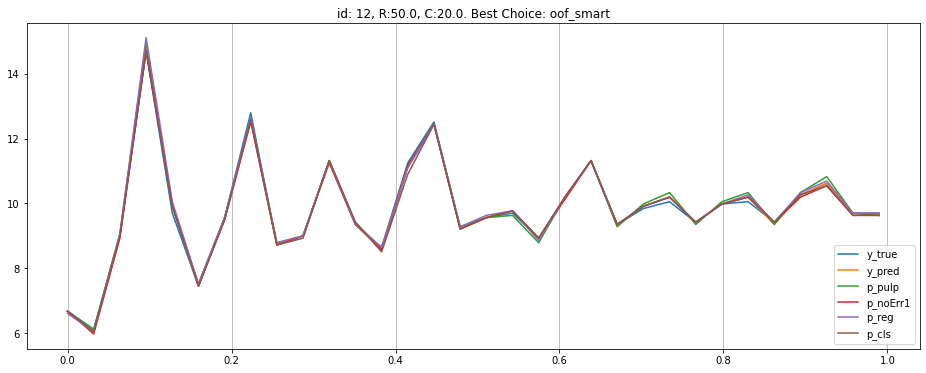

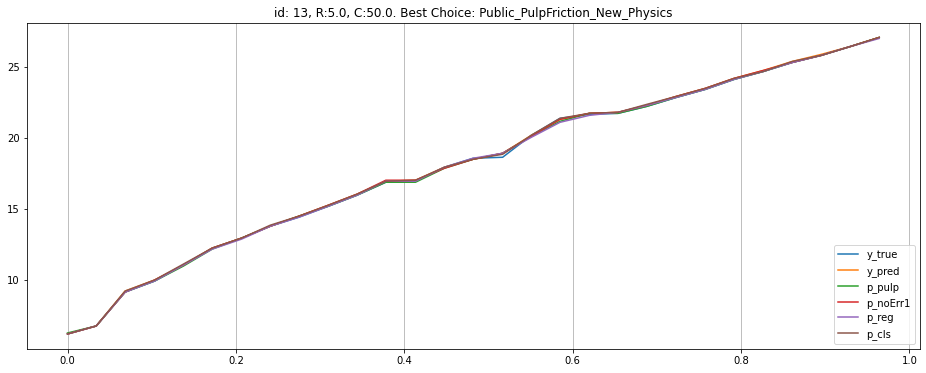

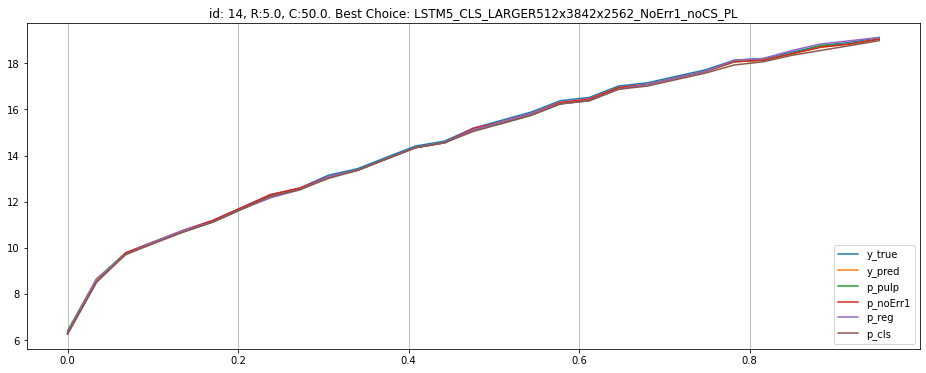

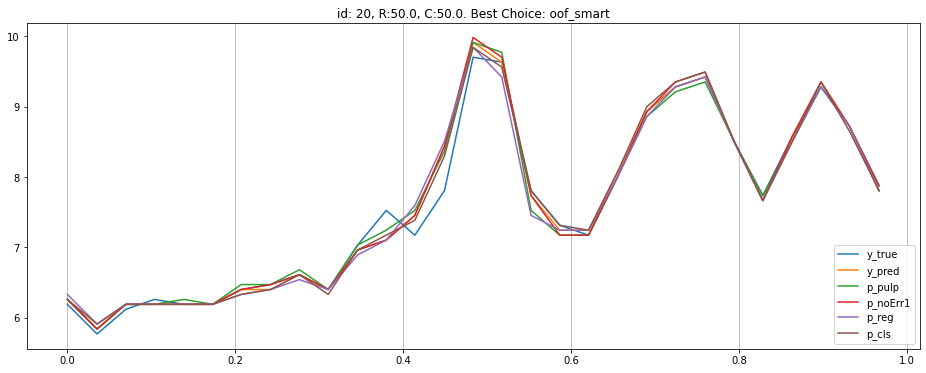

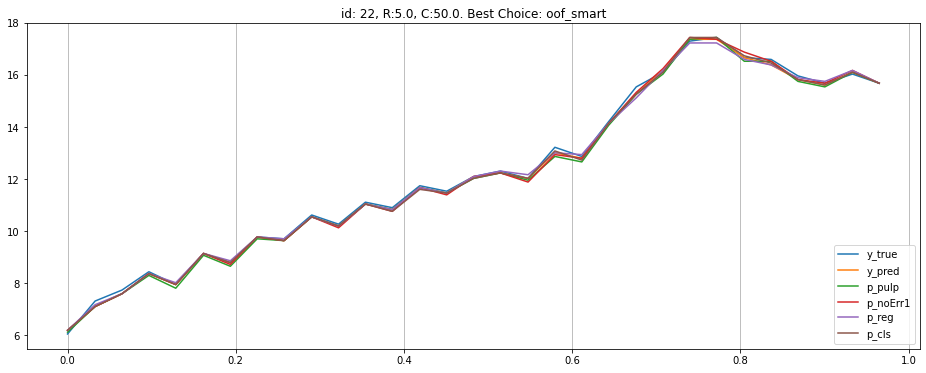

In [23]:
for i in range(10):    
    fig, ax = plt.subplots(1,1, figsize=(16,6))
    plot_error(related_train, ax, good_score.index[i])

In [24]:
breath_score_df = related_train.groupby("breath_id").apply(lambda df: np.mean(np.abs(df["pressure"]-df['oof_smart']))).to_frame(name="oof_smart")
for col in tqdm(model_cols + ["oof_median","oof_avg"]):
    breath_score_df[col] = related_train.groupby("breath_id").apply(lambda df: np.mean(np.abs(df["pressure"]-df[col])))

100%|███████████████████████████████████████████████████████████████████████████| 14/14 [03:16<00:00, 14.05s/it]


In [26]:
breath_score_df["best_choice"] = breath_score_df.idxmin(axis=1)

In [27]:
breath_score_df["R"] = related_train.groupby("breath_id")["R"].last()
breath_score_df["C"] = related_train.groupby("breath_id")["C"].last()

In [28]:
breath_score_df.head()

,oof_smart,Public_PulpFriction_New,Public_PulpFriction_New_Physics,LSTM5_CLS_FIXED_NoErr1_noCS_PL,LSTM5_REG_LARGER_physics_noCS_noErr1_PL,LSTM5_CLS_LARGER512x3842x2562_NoErr1_noCS_PL,LSTM5_REG_physics_PL_better_2,LSTM5_REG_physics_noCS_PL,LSTM5_REG_LARGER_physics_noCS_PL,LSTM5_CLS_FIXED_noCS_PL,LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,oof_median,oof_avg,best_choice,R,C
breath_id,,,,,,,,,,,,,,,,,,
1,0.065615,0.044525,0.065615,0.077332,0.112483,0.060929,0.065615,0.053898,0.084363,0.084363,0.100766,0.089049,0.105453,0.067959,0.065615,Public_PulpFriction_New,20,50
2,0.111514,0.121211,0.067878,0.155150,0.109090,0.203634,0.218179,0.077575,0.176967,0.162422,0.082423,0.072726,0.104241,0.111514,0.111514,Public_PulpFriction_New_Physics,20,20
3,0.057120,0.079090,0.083484,0.083484,0.101059,0.061514,0.087878,0.092272,0.127423,0.090075,0.090075,0.068105,0.087878,0.061514,0.057120,oof_smart,50,20
4,0.125226,0.221891,0.213103,0.166968,0.164771,0.169165,0.204316,0.213103,0.199922,0.153786,0.202119,0.134013,0.107650,0.131817,0.131817,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,50,50
5,0.026666,0.065454,0.043636,0.036363,0.046060,0.029091,0.041212,0.043636,0.036363,0.019394,0.050908,0.041212,0.036363,0.024242,0.026666,LSTM5_CLS_FIXED_noCS_PL,5,50


In [29]:
best_counts = breath_score_df["best_choice"].value_counts()
best_counts

Public_PulpFriction_New_Physics                 9797
Public_PulpFriction_New                         8510
oof_smart                                       5741
LSTM5_CLS_LARGER512x3842x2562_NoErr1_noCS_PL    5657
LSTM5_CLS_LARGER512x3842x2562_noCS_PL           5596
LSTM5_REG_LARGER_physics_noCS_noErr1_PL         5376
LSTM5_REG_LARGER_physics_noCS_PL                5280
LSTM5_REG_physics_noCS_PL                       4924
LSTM5_REG_physics_PL_better_2                   4513
LSTM5_CLS_FIXED_NoErr1_noCS_PL                  4099
LSTM5_CLS_FIXED_noCS_PL                         4028
LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL         3974
oof_median                                      3474
LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3        3081
oof_avg                                         1400
Name: best_choice, dtype: int64

In [30]:
related_train["max_pred"] = related_train[model_cols].max(axis=1)
related_train["min_pred"] = related_train[model_cols].min(axis=1)
related_train["spread"] = related_train["max_pred"] - related_train["min_pred"]

In [31]:
breath_score_df["max_spread"] = related_train.groupby("breath_id")['spread'].max()
breath_score_df["min_spread"] = related_train.groupby("breath_id")['spread'].min()
breath_score_df["mean_spread"] = related_train.groupby("breath_id")['spread'].mean()
breath_score_df["median_spread"] = related_train.groupby("breath_id")['spread'].median()

In [32]:
mean_spread_thresh = breath_score_df.groupby("best_choice")["mean_spread"].mean().sort_values()
median_spread_thresh = breath_score_df.groupby("best_choice")["median_spread"].median().sort_values()
mean_spread_thresh

best_choice
oof_smart                                       0.247397
oof_median                                      0.257348
LSTM5_CLS_LARGER512x3842x2562_NoErr1_noCS_PL    0.313765
LSTM5_REG_LARGER_physics_noCS_PL                0.314986
LSTM5_REG_physics_noCS_PL                       0.321495
LSTM5_CLS_LARGER512x3842x2562_noCS_PL           0.321888
LSTM5_REG_LARGER_physics_noCS_noErr1_PL         0.322134
LSTM5_CLS_FIXED_noCS_PL                         0.332733
LSTM5_REG_physics_PL_better_2                   0.335409
Public_PulpFriction_New_Physics                 0.337079
Public_PulpFriction_New                         0.339206
LSTM5_CLS_FIXED_NoErr1_noCS_PL                  0.340688
LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3        0.348084
LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL         0.357511
oof_avg                                         0.468881
Name: mean_spread, dtype: float64

In [33]:
median_spread_thresh

best_choice
oof_smart                                       0.210906
oof_median                                      0.210906
LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL         0.210906
LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3        0.210906
LSTM5_CLS_FIXED_NoErr1_noCS_PL                  0.210906
LSTM5_CLS_FIXED_noCS_PL                         0.210906
LSTM5_CLS_LARGER512x3842x2562_NoErr1_noCS_PL    0.210906
LSTM5_CLS_LARGER512x3842x2562_noCS_PL           0.210906
LSTM5_REG_LARGER_physics_noCS_PL                0.210906
LSTM5_REG_LARGER_physics_noCS_noErr1_PL         0.210906
Public_PulpFriction_New_Physics                 0.210906
Public_PulpFriction_New                         0.210906
LSTM5_REG_physics_PL_better_2                   0.210906
LSTM5_REG_physics_noCS_PL                       0.210906
oof_avg                                         0.281209
Name: median_spread, dtype: float64

In [34]:
breath_score_df["choice_from_mean_spread"] = breath_score_df["mean_spread"].apply(lambda x: np.abs(mean_spread_thresh - x).idxmin())

In [35]:
breath_score_df["score_from_mean_spread"] = breath_score_df.apply(lambda s: s.loc[s["choice_from_mean_spread"]], axis=1)

In [36]:
breath_count = related_train.groupby("breath_id").size()

In [37]:
(breath_score_df["score_from_mean_spread"] * breath_count) .sum()/breath_count.sum()

0.1535783939813761

In [38]:
(breath_score_df["oof_smart"] * breath_count) .sum()/breath_count.sum()

0.14662160646522052

In [39]:
(breath_score_df["Public_PulpFriction_New_Physics"] * breath_count) .sum()/breath_count.sum()

0.16514775403767357

In [40]:
best_breath_scores = breath_score_df.apply(lambda s: s.loc[s.best_choice], axis=1)#.mean()
(best_breath_scores * breath_count) .sum()/breath_count.sum()

0.09731395108367234

In [41]:
breath_score_df["choice_from_median_spread"] = breath_score_df["median_spread"].apply(lambda x: "Public_PulpFriction_New_Physics" if x == median_spread_thresh.loc["Public_PulpFriction_New_Physics"] else "oof_smart")

In [42]:
breath_score_df["choice_from_median_spread"].value_counts()

oof_smart                          68416
Public_PulpFriction_New_Physics     7034
Name: choice_from_median_spread, dtype: int64

In [43]:
breath_score_df["score_from_median_spread"] = breath_score_df.apply(lambda s: s.loc[s["choice_from_median_spread"]], axis=1)

In [44]:
(breath_score_df["score_from_median_spread"] * breath_count) .sum()/breath_count.sum()

0.14802834412011442

In [45]:
choice_prob = breath_score_df["best_choice"].value_counts(normalize=True)

In [46]:
breath_score_df["choice_from_prob"] = np.random.choice(choice_prob.index, size=len(breath_score_df), 
                                                       replace=True, p=choice_prob)

In [47]:
breath_score_df["score_from_prob"] = breath_score_df.apply(lambda s: s.loc[s["choice_from_prob"]], axis=1)
(breath_score_df["score_from_prob"] * breath_count) .sum()/breath_count.sum()

0.16365202508221058

In [48]:
for lim in range(9):
    lim = lim / 10
    col =f"smart_{lim*10:.0f}_avg"
    related_train[col] = transform_pv(smart_avg(related_train[model_cols], axis=1, spread_lim=lim))
    cv = related_train.groupby("fold").apply(lambda df: np.mean(np.abs(df["pressure"]-df[col]))).mean()
    print(col, cv)

smart_0_avg 0.1470767296428215
smart_1_avg 0.1470815472380543
smart_2_avg 0.14692427493585627
smart_3_avg 0.14669056632608313
smart_4_avg 0.146635207130496
smart_5_avg 0.14660673071902725
smart_6_avg 0.14660835671593472
smart_7_avg 0.14662164742940934
smart_8_avg 0.1466673416611278


In [49]:
related_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold,Public_PulpFriction_New,...,spread,smart_0_avg,smart_1_avg,smart_2_avg,smart_3_avg,smart_4_avg,smart_5_avg,smart_6_avg,smart_7_avg,smart_8_avg
0,1,1,20,50,0.000000,0.083334,0,5.837492,4,5.837492,...,0.210906,5.837492,5.837492,5.837492,5.837492,5.837492,5.837492,5.837492,5.837492,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794,4,5.978096,...,0.140604,5.837492,5.837492,5.837492,5.837492,5.837492,5.837492,5.837492,5.837492,5.837492
2,3,1,20,50,0.067514,22.509277,0,7.876254,4,8.016858,...,0.210906,7.876254,7.876254,7.876254,7.876254,7.876254,7.876254,7.876254,7.876254,7.876254
3,4,1,20,50,0.101542,22.808823,0,11.742872,4,11.883476,...,0.140604,11.883476,11.883476,11.883476,11.883476,11.883476,11.883476,11.883476,11.883476,11.883476
4,5,1,20,50,0.135756,25.355850,0,12.234987,4,12.375591,...,0.210906,12.445893,12.445893,12.445893,12.445893,12.445893,12.445893,12.445893,12.445893,12.445893


In [51]:
breath_RC_val_counts = breath_score_df.groupby(["R","C"])["best_choice"].value_counts()

<AxesSubplot:xlabel='R,C,best_choice'>

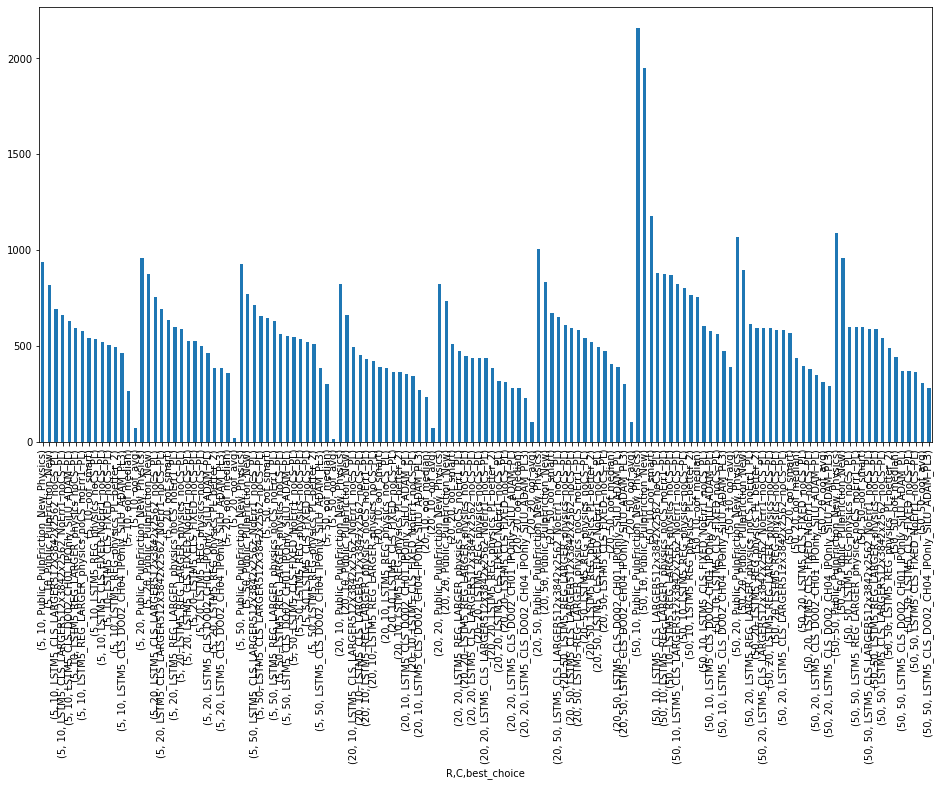

In [52]:
breath_RC_val_counts.plot(kind="bar", figsize=(16,8))

In [53]:
breath_score_df.rename(columns={0:"oof_smart"},inplace=True)

In [54]:
breath_score_df["best_choice"]

breath_id
1                         Public_PulpFriction_New
2                 Public_PulpFriction_New_Physics
3                                       oof_smart
4           LSTM5_CLS_LARGER512x3842x2562_noCS_PL
5                         LSTM5_CLS_FIXED_noCS_PL
                           ...                   
125740      LSTM5_CLS_LARGER512x3842x2562_noCS_PL
125742    LSTM5_CLS_DO02_CH01_IPOnly_SiLU_ADAM_PL
125743            Public_PulpFriction_New_Physics
125745                    LSTM5_CLS_FIXED_noCS_PL
125749                    Public_PulpFriction_New
Name: best_choice, Length: 75450, dtype: object

In [55]:
len(breath_score_df), sum(best_counts)

(75450, 75450)

# Optimization Scipy

In [14]:
# # weight optimization here .....
# sci_opt_preds = train[model_cols + ["pressure","u_out","fold"]].copy() 
# X = sci_opt_preds[model_cols].values
# print(model_cols, sci_opt_preds.shape)
# def get_score(weights, oof=sci_opt_preds):
#     weights = np.array(weights)
#     oof["prediction"] = (weights * X).sum(axis=1)
#     oof["prediction"] = transform_pv(oof["prediction"])
#     return oof.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["prediction"],1-df["u_out"])).mean()

# tol = 1e-10
# init_guess = [1 / len(model_cols)] * len(model_cols)
# bnds = [(-1, 1) for _ in range(len(model_cols))]
# print('Inital Blend OOF: {:.6f}'.format(-get_score(init_guess)))
# res_scipy = minimize(fun = get_score, 
#                     x0 = init_guess, 
#                     method = 'Nelder-Mead', 
#                     bounds = bnds, 
#                     tol = tol)
# print('Optimised Blend OOF: {:.6f}'.format(-res_scipy.fun))
# sci_cv_score = -res_scipy.fun
# print('-' * 70)
# for n, key in enumerate(model_cols):
#     print(f'{key:40s} Optimised Weights:', res_scipy.x[n])
# ws = res_scipy.x 
# pd.DataFrame(dict(zip(model_cols,ws)),index=["weight"]).T.plot(kind="barh",figsize=(10,16))

# Optimization LightGBM

In [15]:
import lightgbm as lgb
import optuna
from optuna import Trial
from sklearn.model_selection import KFold

feature_cols = ["R", "C"] + model_cols
target_cols = "pressure"
cat_cols = ["R","C"]
related_train = train.query("u_out==0").copy().reset_index(drop=True)

In [16]:
related_train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["oof_smart"],1-df["u_out"]))

fold
0    0.149136
1    0.144565
2    0.145819
3    0.147322
4    0.146266
dtype: float64

In [17]:
related_train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["oof_smart"],1-df["u_out"])).mean()

0.14662164742940934

In [36]:
def fit_lgbm(trial, train, val, seed=None, cat_features=None, num_rounds=1500):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l1'
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 128, 1024),
        'objective': 'l1',
        'max_depth': -1,
        'learning_rate': 0.01,
        "boosting": "gbdt",
        'device_type':"gpu",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.1, .5),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        "metric": "l1",
        "verbosity": 0,
    }
    params.update({'device_type': 'gpu', 'num_gpu': 1, "gpu_use_dp":False, "gpu_device_id":-1})

    params['seed'] = seed

    early_stop = 100
    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]
    lrs = [0.1]*1000 + [0.01]*1000 + [0.005]*1000 + [0.001] * 1000 + [0.0005] * 1000
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      callbacks=[
                          lgb.early_stopping(early_stop, first_metric_only=True, verbose=True),
                          lgb.reset_parameter(learning_rate = lrs) 
                      ])
    y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)    
    train_score = np.mean(np.abs(transform_pv(y_pred_train)-y_train))
    val_score = np.mean(np.abs(transform_pv(y_pred_valid)-y_valid))
    log = {'train/l1': train_score, 'valid/l1': val_score}
    print('best_score', log)
    return model, log

In [37]:
def objective(trial: Trial, train_df=related_train, fast_check=False, target_meter=0, return_info=False):
    feature_cols = ["R", "C"] + model_cols
    target_cols = "pressure"
    cat_features = ["R","C"]
    num_rounds = 10 if fast_check else 5000
    models = []
    valid_score = 0
    y_valid_pred_total = np.zeros(train_df.shape[0])
    for fold in range(5):
        print(f"Fold {fold}")
        train = train_df.query(f"fold!={fold}")
        valid = train_df.query(f"fold=={fold}")
        valid_idx = valid.index
        train_data = train[feature_cols], train[target_cols]
        valid_data = valid[feature_cols], valid[target_cols]

        print('train', len(train), 'valid', len(valid))
        model, log = fit_lgbm(trial, train_data, valid_data, 
                                            cat_features=cat_features,
                                            seed = 2021 + fold,
                                            num_rounds=num_rounds)
        models.append(model)
        gc.collect()
        valid_score += log["valid/l1"]
    valid_score /= len(models)
    if return_info:
        return valid_score, models
    else:
        return valid_score

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2021-11-03 15:28:51,043] A new study created in memory with name: no-name-74e359f9-caf9-46db-b5e5-2940b61349e0
/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Fold 0
train 1832678 valid 458290
training LGB:


/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[254]	training's l1: 0.141853	valid_1's l1: 0.158102
Evaluated only: l1
best_score {'train/l1': 0.14016076868805052, 'valid/l1': 0.15661613414637854}
Fold 1
train 1832697 valid 458271
training LGB:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[302]	training's l1: 0.140908	valid_1's l1: 0.152728
Evaluated only: l1
best_score {'train/l1': 0.13922525108948514, 'valid/l1': 0.15115426863402043}
Fold 2
train 1832568 valid 458400
training LGB:
[LightGBM] [Warning] No further spl

[I 2021-11-03 15:33:18,178] Trial 0 finished with value: 0.15322621664500208 and parameters: {'num_leaves': 893, 'lambda_l1': 5.907100911675482e-06, 'lambda_l2': 0.6137659016081212, 'bagging_fraction': 0.4298386872216009, 'feature_fraction': 0.832824531963987}. Best is trial 0 with value: 0.15322621664500208.


best_score {'train/l1': 0.1405062216084205, 'valid/l1': 0.15207579473079433}
Fold 0


/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train 1832678 valid 458290
training LGB:


/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[475]	training's l1: 0.145557	valid_1's l1: 0.158539
Evaluated only: l1
best_score {'train/l1': 0.14387220800072267, 'valid/l1': 0.15696742244217868}
Fold 1
train 1832697 valid 458271
training LGB:
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[529]	training's l1: 0.145316	valid_1's l1: 0.152357
Evaluated only: l1
best_score {'train/l1': 0.14362881866731964, 'valid/l1': 0.1507730513380414}
Fold 2
train 1832568 valid 458400
training LGB:
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[459]	training's l1: 0.146134	valid_1's l1: 0.153624
Evaluated only: l1
best_score {'train/l1': 0.14442977494619927, 'valid/l1': 0.15199802342870236}
Fold 3
train 1832913 valid 458055
training LGB:
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[339]	training's l1

[I 2021-11-03 15:37:21,243] Trial 1 finished with value: 0.153348011824259 and parameters: {'num_leaves': 305, 'lambda_l1': 0.00018745864187697287, 'lambda_l2': 0.0002989015195458161, 'bagging_fraction': 0.24175381423843248, 'feature_fraction': 0.952983682629287}. Best is trial 0 with value: 0.15322621664500208.


best_score {'train/l1': 0.14442914680127583, 'valid/l1': 0.15266145149153287}
Fold 0


/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train 1832678 valid 458290
training LGB:


/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[246]	training's l1: 0.143696	valid_1's l1: 0.158391
Evaluated only: l1
best_score {'train/l1': 0.14203843045707593, 'valid/l1': 0.15683887240205743}
Fold 1
train 1832697 valid 458271
training LGB:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	training's l1: 0.142175	valid_1's l1: 0.152719
Evaluated only: l1
best_score {'train/l1': 0.1404779332632702, 'valid/l1': 0.1511504334499579}
Fold 2
train 1832568 valid 458400
training LGB:
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positi

[I 2021-11-03 15:41:20,976] Trial 2 finished with value: 0.15339866018121798 and parameters: {'num_leaves': 779, 'lambda_l1': 2.9965879875377698e-06, 'lambda_l2': 0.03534466235342974, 'bagging_fraction': 0.3675473713087135, 'feature_fraction': 0.9612608024702649}. Best is trial 0 with value: 0.15322621664500208.


best_score {'train/l1': 0.14195217799158727, 'valid/l1': 0.15232341317249795}
Fold 0


/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


train 1832678 valid 458290
training LGB:


/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/vincent/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	training's l1: 0.141854	valid_1's l1: 0.158414
Evaluated only: l1


In [91]:
# We will track how many training rounds we needed for our best score.
# We will use that number of rounds later.
best_score = 999
training_rounds = 10000

def objective(trial):
    param = {
        "objective": "mae",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt", 
        "lr": 0.01,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'seed': 2021
    }
    
    # Run LightGBM for the hyperparameter values
    lgbcv = lgb.cv(param,
                   dtrain,
                   categorical_feature=cat_cols,
                   folds=kf,
                   num_boost_round=100,                    
                  )
    print(lgbcv)
    cv_score = lgbcv['l1-mean'][-1]
    if cv_score<best_score:
        training_rounds = len( list(lgbcv.values())[0] )
        best_score = cv_score
    
    # Return metric of interest
    return cv_score

# Suppress information only outputs - otherwise optuna is 
# quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# We search for another 4 hours (3600 s are an hours, so timeout=14400).
# We could instead do e.g. n_trials=1000, to try 1000 hyperparameters chosen 
# by optuna or set neither timeout or n_trials so that we keep going until 
# the user interrupts ("Cancel run").
study = optuna.create_study(direction='minimize')  
study.optimize(objective, timeout=1) 

[W 2021-11-03 13:54:22,069] Trial 0 failed because of the following error: KeyError('mae-mean')
Traceback (most recent call last):
  File "/home/vincent/.local/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2751419/4056277259.py", line 31, in objective
    cv_score = lgbcv['mae-mean']
KeyError: 'mae-mean'


{'l1-mean': [6.819258950423188, 6.1928520147968245, 5.6316059647695385, 5.123767203672334, 4.664250344232065, 4.245388183242831, 3.864711364068827, 3.52063691437977, 3.207735624948563, 2.9243634845558466], 'l1-stdv': [0.006189466454096774, 0.006175718235404333, 0.0074011560118219626, 0.009008524521328184, 0.011789601140429047, 0.013577880617724235, 0.014699071055777897, 0.015050451991168702, 0.015343031085582045, 0.014799165768858915]}


KeyError: 'mae-mean'

In [82]:


params = {
        "objective": "mae",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42
    }


study_tuner = optuna.create_study(direction='minimize')
dtrain = lgb.Dataset(X, label=y)

# Suppress information only outputs - otherwise optuna is 
# quite verbose, which can be nice, but takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Run optuna LightGBMTunerCV tuning of LightGBM with cross-validation
tuner = lgb.LightGBMTunerCV(params, 
                            dtrain, 
                            categorical_feature=cat_cols,
                            study=study_tuner,
                            verbose_eval=False,                            
                            early_stopping_rounds=250,
                            time_budget=60, # Time budget of 5 hours, we will not really need it
                            seed = 42,
                            folds= kf,
                            num_boost_round=10000,
                            callbacks=[lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ] 
)

tuner.run()

ModuleNotFoundError: No module named 'optuna'

In [81]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=10, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

# Submission

In [72]:
# weights here ....        
use_sci = True
if use_sci:
    train["pressure_smart"] = transform_pv((train[list(subs.keys())] * ws).sum(axis=1))
else:
    train["pressure_smart"] = transform_pv(smart_avg(train[list(subs.keys())],axis=1))
CVs = train.groupby("fold").apply(lambda df: cal_mae_metric(df["pressure"],df["pressure_smart"],1-df["u_out"]))
CV = np.mean(CVs)
print(CVs)
print("Ensemble CV: Mean {:.4f}, std {:.4f}".format(np.mean(CVs), np.std(CVs)))

fold
0    0.150198
1    0.145809
2    0.146159
3    0.148104
4    0.147246
dtype: float64
Ensemble CV: Mean 0.1475, std 0.0016


In [73]:
id_score = train.groupby("breath_id").apply(lambda df: cal_mae_metric(df["pressure"], df["pressure_smart"],1-df["u_out"]))

In [74]:
id_score.describe()

count    7.545000e+04
mean     1.464348e-01
std      2.357373e-01
min      9.630519e-13
25%      5.575687e-02
50%      8.617682e-02
75%      1.478769e-01
max      2.030110e+01
dtype: float64

In [75]:
np.sum(id_score > 1)

863

In [76]:
# for fold in tqdm(range(5)):
#     sub_keys = [key+f"_{fold}" for key in subs.keys()]
#     #test_fold_pred = transform_pv((sub_all[sub_keys] * ws).sum(axis=1))
#     test_fold_pred = transform_pv(smart_avg(sub_all[sub_keys], axis=1))
#     sub_fold = sub_all[["id"]].copy()
#     sub_fold[f'preds_fold{fold}'] = test_fold_pred
#     sub_fold.to_csv(ensemble_folder + f"/test_fold{fold}.csv",index=False)

if use_sci:
    sub_all["pressure"] = transform_pv((sub_all[model_cols] * ws).sum(axis=1))
else:
    sub_all["pressure"] = transform_pv(smart_avg(sub_all[model_cols], axis=1))
if use_sci:
    path = ensemble_folder + f"/submission_{CV*1e5:.0f}_sci.csv"
else:
    path = ensemble_folder + f"/submission_{CV*1e5:.0f}_nosci.csv"
print(path)
sub_all[["id","pressure"]].to_csv(path,index=False)    
print(sub_all.shape, train.shape)
sub_all

/home/vincent/Kaggle/GBVPP/output//ensemble_1103/submission_14750_sci.csv
(4024000, 77) (6036000, 25)


,id,pressure,Public_PulpFriction_New_0,Public_PulpFriction_New_1,Public_PulpFriction_New_2,Public_PulpFriction_New_3,Public_PulpFriction_New_4,Public_PulpFriction_New,Public_PulpFriction_New_Physics_0,Public_PulpFriction_New_Physics_1,...,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_0,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_1,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_2,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_4,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,sub_1336,sub_1348,pressure_pub
0,1,6.259305,6.329606,6.329606,6.329606,6.259304,6.329606,6.329607,6.329606,6.259304,...,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305,6.329607,6.329607,6.329607
1,2,5.907794,5.978096,5.978096,5.978096,5.907794,5.978096,5.978096,5.978096,5.978096,...,5.907794,5.978096,5.978096,5.907794,5.907794,5.978096,5.978096,5.978096,5.978096,5.978096
2,3,7.102930,7.032628,7.173232,7.102930,7.102930,7.173232,7.102930,6.962326,7.102930,...,7.102930,7.102930,7.173232,7.102930,7.102930,7.102930,7.102930,7.102930,7.102930,7.102930
3,4,7.595045,7.595045,7.735649,7.595045,7.595045,7.665347,7.665347,7.665347,7.665347,...,7.595045,7.595045,7.595045,7.595045,7.595045,7.665347,7.595045,7.595045,7.665347,7.595045
4,5,9.141693,9.141692,9.211994,9.001088,9.141692,9.141692,9.141693,9.141692,9.282296,...,9.071390,9.071390,9.141693,9.071390,9.141693,9.141693,9.141693,9.141693,9.211995,9.141693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023995,4023996,6.118700,6.189002,6.259304,6.189002,6.259304,6.189002,6.189002,6.259304,6.189002,...,14.133145,9.071390,10.125923,11.391361,11.672570,11.250757,11.250757,6.189002,6.189002,6.189002
4023996,4023997,6.118700,6.329606,6.189002,6.259304,6.189002,6.259304,6.259305,6.259304,6.259304,...,12.938008,9.071390,55.330202,11.602268,11.883476,11.602268,11.602268,6.259305,6.329607,6.329607
4023997,4023998,6.329607,6.329606,6.470211,6.470211,6.470211,6.470211,6.470211,6.470211,6.470211,...,13.359821,9.141693,12.024081,11.813174,11.883476,12.938008,11.883476,6.470211,6.399909,6.470211
4023998,4023999,6.329607,6.189002,6.259304,6.189002,6.259304,6.189002,6.189002,6.189002,6.189002,...,14.133145,9.282297,11.883476,11.813174,12.445893,13.289519,11.883476,6.189002,6.189002,6.189002


# Best Public Score One

In [63]:
pub_sub1 = pd.read_csv("../output/1336_submission.csv")
pub_sub2 = pd.read_csv("../output/1348_submission.csv")

In [64]:
sub_all["sub_1336"] = pub_sub1["pressure"]
sub_all["sub_1348"] = pub_sub2["pressure"]
sub_all.head()

,id,pressure,Public_PulpFriction_New_0,Public_PulpFriction_New_1,Public_PulpFriction_New_2,Public_PulpFriction_New_3,Public_PulpFriction_New_4,Public_PulpFriction_New,Public_PulpFriction_New_Physics_0,Public_PulpFriction_New_Physics_1,...,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3_4,LSTM5_CLS_DO02_CH04_IPOnly_SiLU_ADAM_PL3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_0,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_1,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_2,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_3,LSTM5_CLS_LARGER512x3842x2562_noCS_PL_4,LSTM5_CLS_LARGER512x3842x2562_noCS_PL,sub_1336,sub_1348
0,1,6.259305,6.329606,6.329606,6.329606,6.259304,6.329606,6.329607,6.329606,6.259304,...,6.189002,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305,6.329607,6.329607
1,2,5.907794,5.978096,5.978096,5.978096,5.907794,5.978096,5.978096,5.978096,5.978096,...,5.978096,5.907794,5.978096,5.978096,5.907794,5.907794,5.978096,5.978096,5.978096,5.978096
2,3,7.102930,7.032628,7.173232,7.102930,7.102930,7.173232,7.102930,6.962326,7.102930,...,7.102930,7.102930,7.102930,7.173232,7.102930,7.102930,7.102930,7.102930,7.102930,7.102930
3,4,7.595045,7.595045,7.735649,7.595045,7.595045,7.665347,7.665347,7.665347,7.665347,...,7.665347,7.595045,7.595045,7.595045,7.595045,7.595045,7.665347,7.595045,7.595045,7.665347
4,5,9.071390,9.141692,9.211994,9.001088,9.141692,9.141692,9.141693,9.141692,9.282296,...,9.071390,9.071390,9.071390,9.141693,9.071390,9.141693,9.141693,9.141693,9.141693,9.211995


In [69]:
use_all = False
if use_all:
    sub_all["pressure_pub"] = transform_pv(smart_avg(sub_all[["sub_1336","sub_1348"] + model_cols],axis=1))
else:
    sub_all["pressure_pub"] = transform_pv(smart_avg(sub_all[["sub_1336","sub_1348","pressure"]],axis=1))    

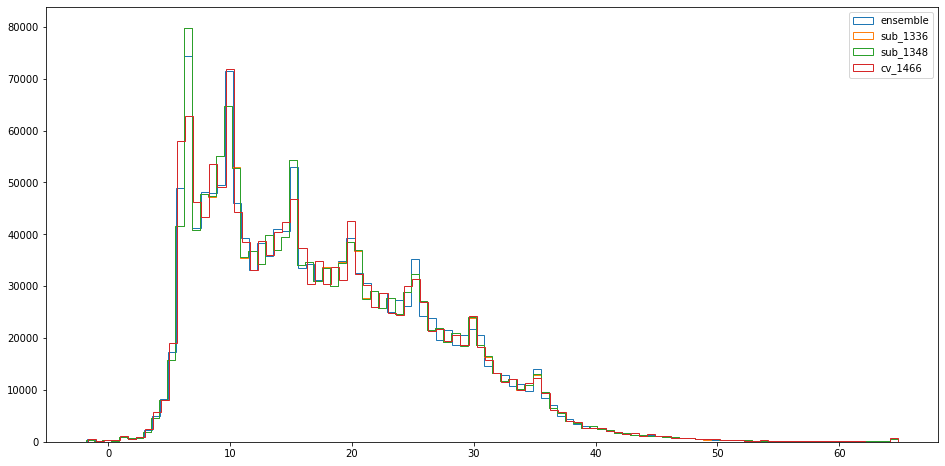

In [70]:
fig,ax= plt.subplots(1,1,figsize=(16,8))
ax.hist(sub_all.loc[test.query("u_out==0").index,"pressure_pub"], bins=100, label="ensemble", alpha=1,histtype="step")
ax.hist(sub_all.loc[test.query("u_out==0").index,"sub_1336"], bins=100, label="sub_1336", alpha=1,histtype="step")
ax.hist(sub_all.loc[test.query("u_out==0").index,"sub_1348"], bins=100, label="sub_1348", alpha=1,histtype="step")
ax.hist(sub_all.loc[test.query("u_out==0").index,"pressure"], bins=100, label=f"cv_{CV*1e4:.0f}", alpha=1,histtype="step")
plt.legend()
plt.show()

In [71]:
if use_all:
    path = ensemble_folder + f"/submission_{CV*1e5:.0f}_withPub_all.csv"
else:
    path = ensemble_folder + f"/submission_{CV*1e5:.0f}_withPub_only3.csv"
print(path)
sub_all[["id","pressure_pub"]].rename(columns={"pressure_pub":"pressure"}).to_csv(path,index=False)

/home/vincent/Kaggle/GBVPP/output//ensemble_1103/submission_14662_withPub_only3.csv
